In [101]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for working with dates and times
import datetime as dt

# Import TensorFlow and Keras libraries for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Reshape, Flatten, GRU
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import scikit-learn library for various metrics and preprocessing tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Import matplotlib library for creating plots and charts
import matplotlib.pyplot as plt

# Magic command to display plots inline in the Jupyter Notebook
%matplotlib inline

In [102]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [103]:
# Read in the Gold dataset from a CSV file
df=pd.read_csv("../dataset/cleaned_NEM.csv")
df=df.set_index(pd.DatetimeIndex(df['Date'].values))


# Preprocessing Data

---

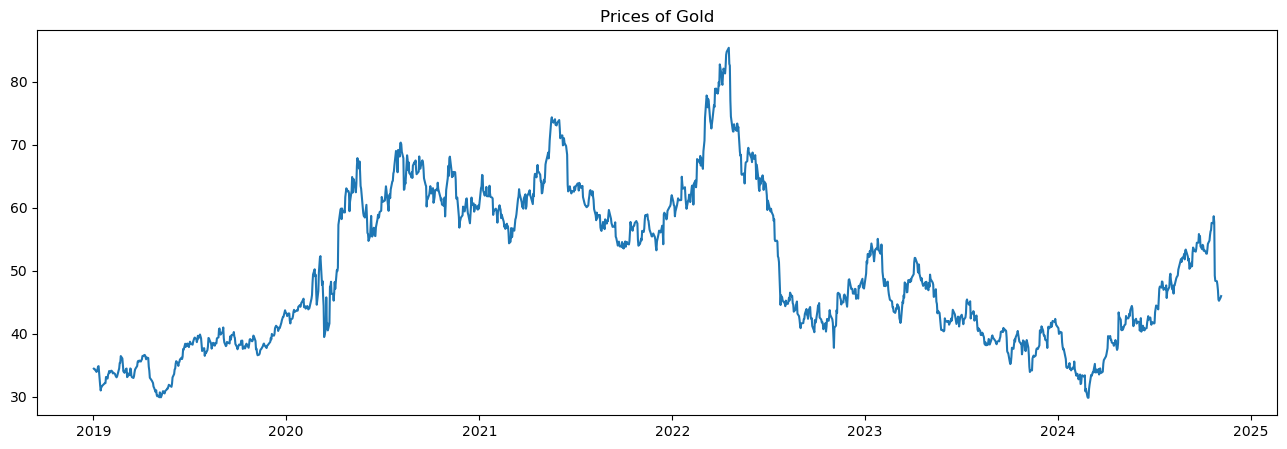

In [104]:
# Format column Date
df.index = pd.to_datetime(df.index, format='%m/%d/%Y')

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['Date', 'Close'])
df1.drop('Date', axis=1, inplace=True)

# Plot the 'price' column of the 'df' DataFrame
plt.figure(figsize=(16, 5))
plt.plot(df1['Close'])
plt.title('Prices of Gold')
plt.show()

# Split dataset (7-2-1)

---



In [105]:
# Create a MinMaxScaler object with a specified range
data = df1.values
sc = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the data
sc_train = sc.fit_transform(data)

# Split the data
train_size = int(0.7 * len(sc_train))
test_size = int(0.2 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [106]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [107]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [108]:
# Build the model
model = Sequential()

# Add a GRU layer with 50 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(GRU(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add another GRU layer with 50 units and return_sequences set to True
model.add(GRU(50, return_sequences=True))

# Add a final GRU layer with 50 units
model.add(GRU(50))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')

# Set the filename to use for saving the model with the correct '.keras' extension
save_model = 'save_model_7_2_1.keras'

# Create a ModelCheckpoint object to save the best model during training
best_model = ModelCheckpoint(
    filepath=save_model,
    monitor='loss',
    verbose=2,
    save_best_only=True,
    mode='auto'
)

# Train the model using the 'fit' method
model.fit(
    x_train,
    y_train,
    epochs=80,
    batch_size=50,
    verbose=2,
    callbacks=[best_model]
)

Epoch 1/80


c:\Users\yashi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.17167, saving model to save_model_7_2_1.keras
21/21 - 4s - 180ms/step - loss: 0.1717
Epoch 2/80

Epoch 2: loss improved from 0.17167 to 0.04670, saving model to save_model_7_2_1.keras
21/21 - 0s - 6ms/step - loss: 0.0467
Epoch 3/80

Epoch 3: loss improved from 0.04670 to 0.02793, saving model to save_model_7_2_1.keras
21/21 - 0s - 6ms/step - loss: 0.0279
Epoch 4/80

Epoch 4: loss improved from 0.02793 to 0.02608, saving model to save_model_7_2_1.keras
21/21 - 0s - 6ms/step - loss: 0.0261
Epoch 5/80

Epoch 5: loss improved from 0.02608 to 0.02498, saving model to save_model_7_2_1.keras
21/21 - 0s - 6ms/step - loss: 0.0250
Epoch 6/80

Epoch 6: loss did not improve from 0.02498
21/21 - 0s - 5ms/step - loss: 0.0251
Epoch 7/80

Epoch 7: loss did not improve from 0.02498
21/21 - 0s - 6ms/step - loss: 0.0254
Epoch 8/80

Epoch 8: loss did not improve from 0.02498
21/21 - 0s - 5ms/step - loss: 0.0254
Epoch 9/80

Epoch 9: loss did not improve from 0.02498
21

In [109]:
# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_7_2_1.keras')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step 


In [110]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [111]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [112]:
# Dự báo dữ liệu test, val
train_predict=model.predict(x_train)
y_pred=model.predict(x_test)
y_pred_val=model.predict(x_val)

# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=sc.inverse_transform(train_predict)
y_pred=sc.inverse_transform(y_pred)
y_pred_val=sc.inverse_transform(y_pred_val)
     

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [113]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 5:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 5)
[0.3074153846309132, 0.2804175432724767, 0.2771777967299105, 0.2861770771827227, 0.29049676203765484]


In [114]:
# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.2911684811115265], [0.2917410433292389], [0.29227861762046814], [0.29291993379592896], [0.29358699917793274], [0.29424428939819336], [0.2948927879333496], [0.2955324947834015], [0.29616478085517883], [0.29679015278816223], [0.2974085211753845], [0.29802000522613525], [0.2986246645450592], [0.29922252893447876], [0.2998136281967163], [0.30039817094802856], [0.3009761571884155], [0.3015476167201996], [0.30211272835731506], [0.3026713728904724], [0.30322378873825073], [0.30376997590065], [0.30430999398231506], [0.3048440217971802], [0.3053719997406006], [0.30589401721954346], [0.3064101040363312], [0.3069204092025757], [0.30742499232292175], [0.3079237937927246]]


In [115]:
# Convert the 'Date' column in the dataframe to a list of strings
datelist_train = df['Date'].astype(str).tolist()

# Parse the date strings using strptime(), using the correct format string '%Y-%m-%d'
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Generate a list of future dates, starting from the last date in the training data and going for 30 days
datelist_future = pd.date_range(datelist_train[-1] + dt.timedelta(days=1), periods=30, freq='1d').tolist()

In [116]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[46.03732071]
 [46.06913227]
 [46.09899989]
 [46.13463142]
 [46.17169357]
 [46.20821261]
 [46.24424319]
 [46.2797853 ]
 [46.31491511]
 [46.34966077]
 [46.38401732]
 [46.41799137]
 [46.45158624]
 [46.48480359]
 [46.51764506]
 [46.55012225]
 [46.58223517]
 [46.61398546]
 [46.64538306]
 [46.67642135]
 [46.70711357]
 [46.73745973]
 [46.76746313]
 [46.79713372]
 [46.82646817]
 [46.85547146]
 [46.88414524]
 [46.9124978 ]
 [46.94053243]
 [46.96824584]]


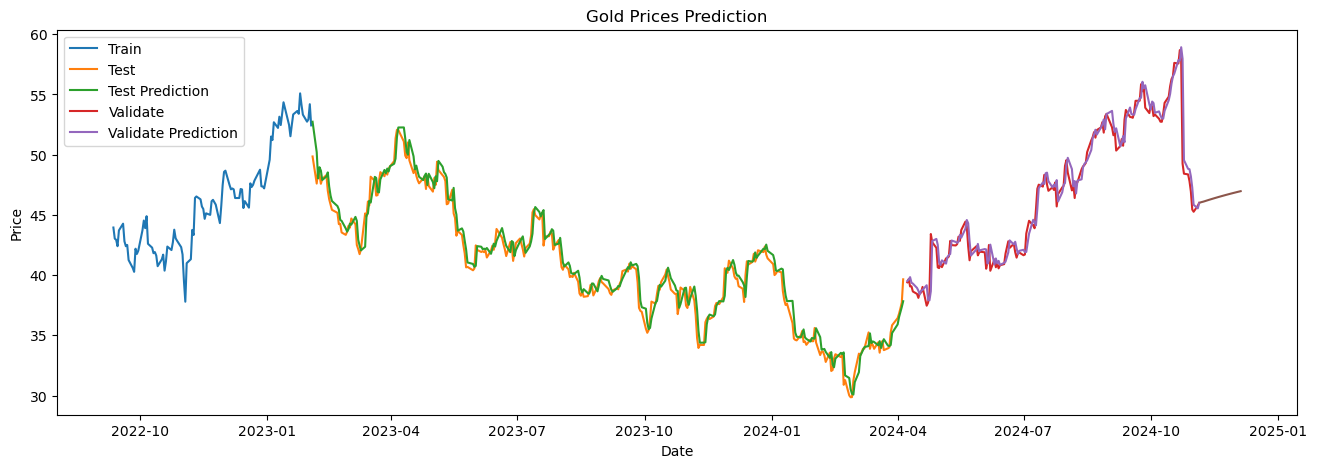

In [117]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Close']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [118]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.6997068820505321
MAPE:  1.7381398370433498
RMSE:  0.9172192983654229

** Validate **
MAE:  0.7059519227987092
MAPE:  1.5225853329236478
RMSE:  1.150146553289098


# Split dataset (6-3-1)

---



In [131]:
# Split the data
train_size = int(0.6 * len(sc_train))
test_size = int(0.3 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [132]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [133]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [134]:
# Set the filename to use for saving the model with the correct .keras extension
save_model = 'save_model_6_3_1.keras'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])


Epoch 1/80

Epoch 1: loss improved from inf to 0.01575, saving model to save_model_6_3_1.keras
18/18 - 0s - 7ms/step - loss: 0.0157
Epoch 2/80

Epoch 2: loss improved from 0.01575 to 0.01551, saving model to save_model_6_3_1.keras
18/18 - 0s - 9ms/step - loss: 0.0155
Epoch 3/80

Epoch 3: loss improved from 0.01551 to 0.01531, saving model to save_model_6_3_1.keras
18/18 - 0s - 7ms/step - loss: 0.0153
Epoch 4/80

Epoch 4: loss did not improve from 0.01531
18/18 - 0s - 5ms/step - loss: 0.0157
Epoch 5/80

Epoch 5: loss did not improve from 0.01531
18/18 - 0s - 5ms/step - loss: 0.0156
Epoch 6/80

Epoch 6: loss improved from 0.01531 to 0.01524, saving model to save_model_6_3_1.keras
18/18 - 0s - 7ms/step - loss: 0.0152
Epoch 7/80

Epoch 7: loss did not improve from 0.01524
18/18 - 0s - 5ms/step - loss: 0.0157
Epoch 8/80

Epoch 8: loss did not improve from 0.01524
18/18 - 0s - 7ms/step - loss: 0.0169
Epoch 9/80

Epoch 9: loss did not improve from 0.01524
18/18 - 0s - 5ms/step - loss: 0.0157


In [135]:
# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_6_3_1.keras')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 


In [136]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [137]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [138]:
# Dự báo dữ liệu test, val
train_predict=model.predict(x_train)
y_pred=model.predict(x_test)
y_pred_val=model.predict(x_val)

# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=sc.inverse_transform(train_predict)
y_pred=sc.inverse_transform(y_pred)
y_pred_val=sc.inverse_transform(y_pred_val)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [139]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 5:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 5)
[0.3074153846309132, 0.2804175432724767, 0.2771777967299105, 0.2861770771827227, 0.29049676203765484]


In [140]:
# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.2968301773071289], [0.30241522192955017], [0.30779609084129333], [0.3131510317325592], [0.31843292713165283], [0.32366836071014404], [0.32884296774864197], [0.3339540958404541], [0.33900195360183716], [0.3439864218235016], [0.3489077091217041], [0.3537658154964447], [0.3585606515407562], [0.36329221725463867], [0.36796045303344727], [0.3725653886795044], [0.3771069645881653], [0.38158538937568665], [0.3860006630420685], [0.39035293459892273], [0.3946423828601837], [0.3988690674304962], [0.4030331075191498], [0.4071347713470459], [0.41117414832115173], [0.4151516258716583], [0.4190674424171448], [0.4229218363761902], [0.4267151355743408], [0.43044769763946533]]


In [141]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[46.35188454]
 [46.6621896 ]
 [46.96115067]
 [47.25867117]
 [47.55213326]
 [47.84301394]
 [48.1305151 ]
 [48.41448936]
 [48.69494832]
 [48.97188537]
 [49.24531208]
 [49.51522846]
 [49.78162953]
 [50.04451531]
 [50.30388248]
 [50.5597327 ]
 [50.81206264]
 [51.06088391]
 [51.30619651]
 [51.5480087 ]
 [51.78633044]
 [52.02116502]
 [52.25251908]
 [52.48040751]
 [52.70483529]
 [52.92582393]
 [53.14338669]
 [53.35753681]
 [53.5682925 ]
 [53.77567364]]


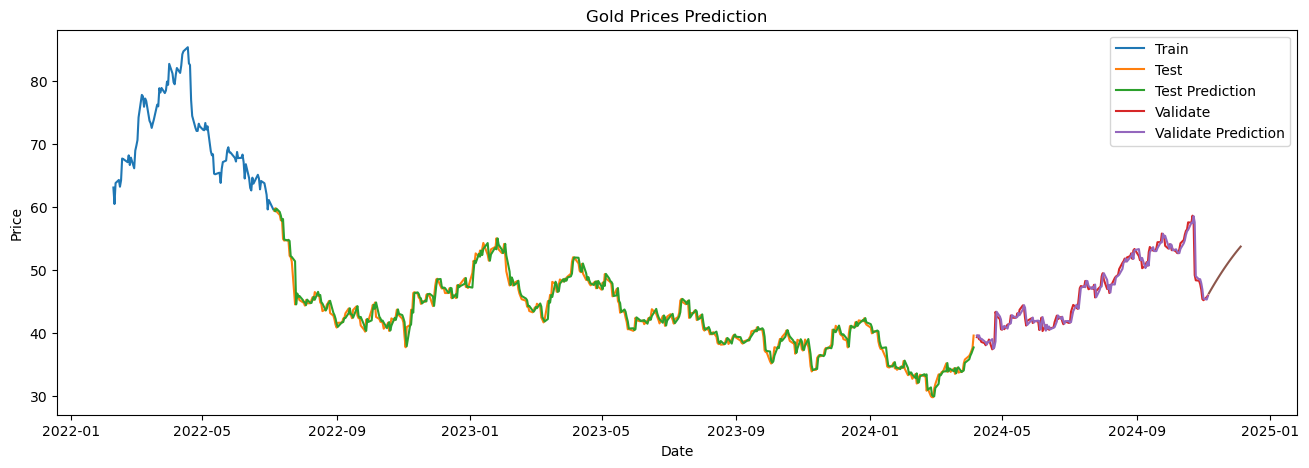

In [142]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [ ]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.7028028269275262
MAPE:  1.6622035900192698
RMSE:  0.9680289734742157

** Validate **
MAE:  0.7204670775782571
MAPE:  1.5411924508272494
RMSE:  1.1197136338971783


# Split dataset (5-3-2)

---



In [89]:
# Split the data
train_size = int(0.5 * len(sc_train))
test_size = int(0.3 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [90]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [91]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [92]:
# Build the model
model = Sequential()

# Add an GRU layer with 50 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(GRU(50,return_sequences=True,input_shape=(x_train.shape[1],1)))

# Add an GRU layer with 50 units
model.add(GRU(50,return_sequences=True))

# Add an GRU layer with 50 units
model.add(GRU(50))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_5_3_2.keras'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80


c:\Users\yashi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.17064, saving model to save_model_5_3_2.keras
15/15 - 4s - 251ms/step - loss: 0.1706
Epoch 2/80

Epoch 2: loss improved from 0.17064 to 0.06738, saving model to save_model_5_3_2.keras
15/15 - 0s - 7ms/step - loss: 0.0674
Epoch 3/80

Epoch 3: loss improved from 0.06738 to 0.02886, saving model to save_model_5_3_2.keras
15/15 - 0s - 7ms/step - loss: 0.0289
Epoch 4/80

Epoch 4: loss improved from 0.02886 to 0.02446, saving model to save_model_5_3_2.keras
15/15 - 0s - 7ms/step - loss: 0.0245
Epoch 5/80

Epoch 5: loss improved from 0.02446 to 0.02307, saving model to save_model_5_3_2.keras
15/15 - 0s - 7ms/step - loss: 0.0231
Epoch 6/80

Epoch 6: loss did not improve from 0.02307
15/15 - 0s - 5ms/step - loss: 0.0231
Epoch 7/80

Epoch 7: loss did not improve from 0.02307
15/15 - 0s - 5ms/step - loss: 0.0235
Epoch 8/80

Epoch 8: loss improved from 0.02307 to 0.02276, saving model to save_model_5_3_2.keras
15/15 - 0s - 7ms/step - loss: 0.0228
Epoch 9/80

E

In [93]:
# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_5_3_2.keras')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [94]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [95]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [96]:
# Dự báo dữ liệu test, val
train_predict=model.predict(x_train)
y_pred=model.predict(x_test)
y_pred_val=model.predict(x_val)

# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=sc.inverse_transform(train_predict)
y_pred=sc.inverse_transform(y_pred)
y_pred_val=sc.inverse_transform(y_pred_val)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [97]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 5:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 5)
[0.3074153846309132, 0.2804175432724767, 0.2771777967299105, 0.2861770771827227, 0.29049676203765484]


In [98]:
# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.28783953189849854], [0.2856135964393616], [0.2833661735057831], [0.28132984042167664], [0.2793642282485962], [0.2773917019367218], [0.27542605996131897], [0.2734658420085907], [0.27151423692703247], [0.269571453332901], [0.2676369547843933], [0.26571041345596313], [0.26379168033599854], [0.26188042759895325], [0.25997647643089294], [0.2580796778202057], [0.2561897337436676], [0.2543065547943115], [0.2524298131465912], [0.2505594491958618], [0.24869513511657715], [0.2468367964029312], [0.24498417973518372], [0.24313712120056152], [0.24129538238048553], [0.2394588142633438], [0.2376273274421692], [0.23580065369606018], [0.23397859930992126], [0.23216107487678528]]


In [99]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[45.8523643 ]
 [45.72869133]
 [45.60382452]
 [45.49068586]
 [45.38147645]
 [45.27188289]
 [45.16267183]
 [45.05376212]
 [44.94533095]
 [44.8373899 ]
 [44.72990916]
 [44.62287053]
 [44.51626573]
 [44.41007653]
 [44.30429301]
 [44.19890688]
 [44.09390159]
 [43.98927217]
 [43.88500041]
 [43.781083  ]
 [43.67750171]
 [43.57425242]
 [43.47132104]
 [43.36869847]
 [43.26637147]
 [43.16433175]
 [43.06257434]
 [42.96108435]
 [42.85985102]
 [42.75886936]]


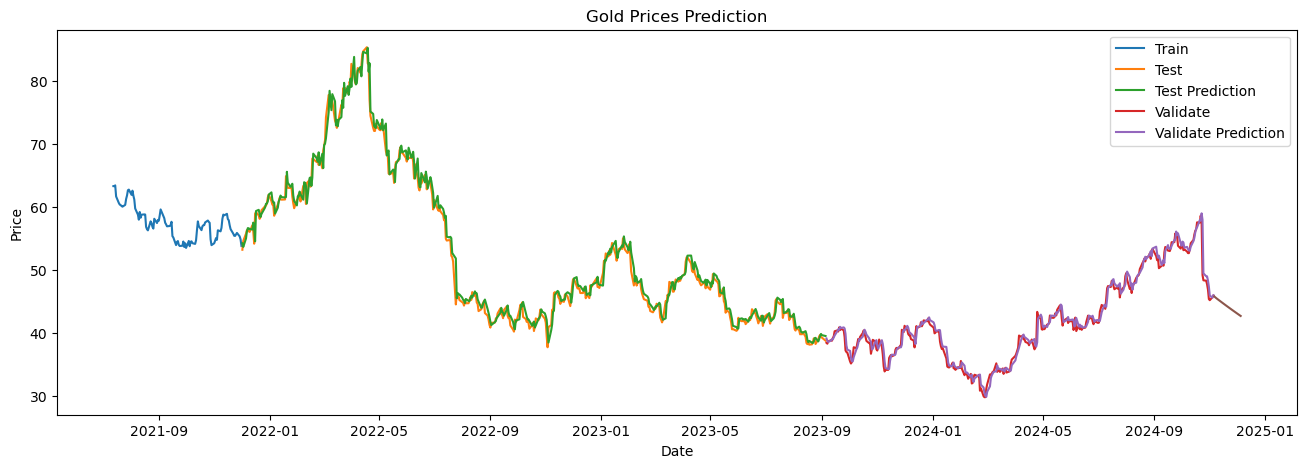

In [100]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [88]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.9088968118443079
MAPE:  1.7045286702040214
RMSE:  1.278066588340565

** Validate **
MAE:  0.6956806441249834
MAPE:  1.6919809178436531
RMSE:  1.0124372731543068


# Evaluating model

---

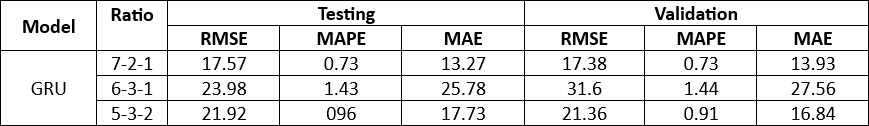
